In [3]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

#plt.rcParams['text.usetex'] = True

In [4]:
from manifpy import SE3, SE3Tangent
import pypose as pp
from scipy.spatial.transform import Rotation as R
from RNN_AUV import plot_traj

# Extract usefull information from the csv file.

In [5]:
path = "./test_data_clean/csv/run0.csv"
df = pd.read_csv(path)

In [12]:
position = df.loc[:, ['x', 'y', 'z']].to_numpy()
orientation = df.loc[:, ['roll', 'pitch', 'yaw']].to_numpy()
quat = df.loc[:, ['qw', 'qx', 'qy', 'qz']].to_numpy()
rot_matrix = df.loc[:, ['r00', 'r01', 'r02', 'r10', 'r11', 'r12', 'r20', 'r21', 'r22']].to_numpy().reshape((-1, 3, 3))
rot_vec = df.loc[:, ['rv0', 'rv1', 'rv2']].to_numpy()
I_vel = df.loc[:, ['Iu', 'Iv', 'Iw', 'Ip', 'Iq', 'Ir']].to_numpy()
B_vel = df.loc[:, ['Bu', 'Bv', 'Bw', 'Bp', 'Bq', 'Br']].to_numpy()

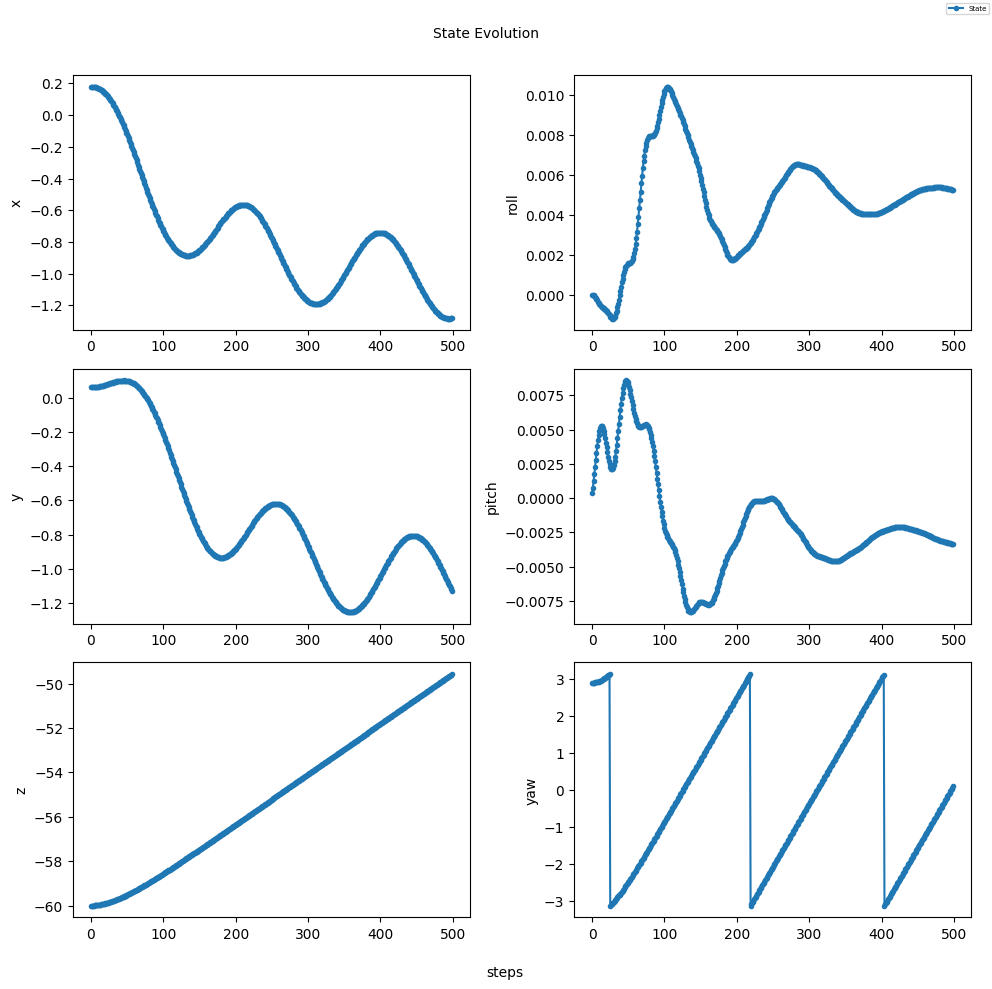

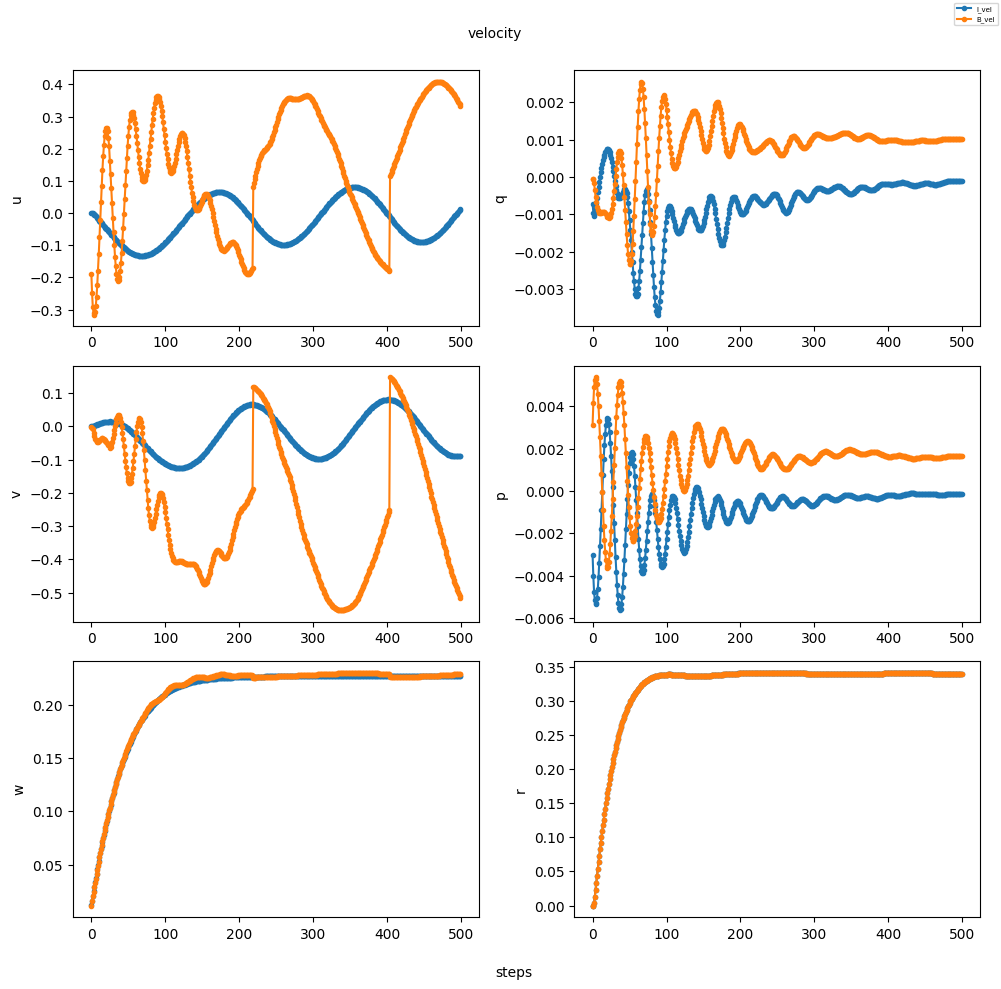

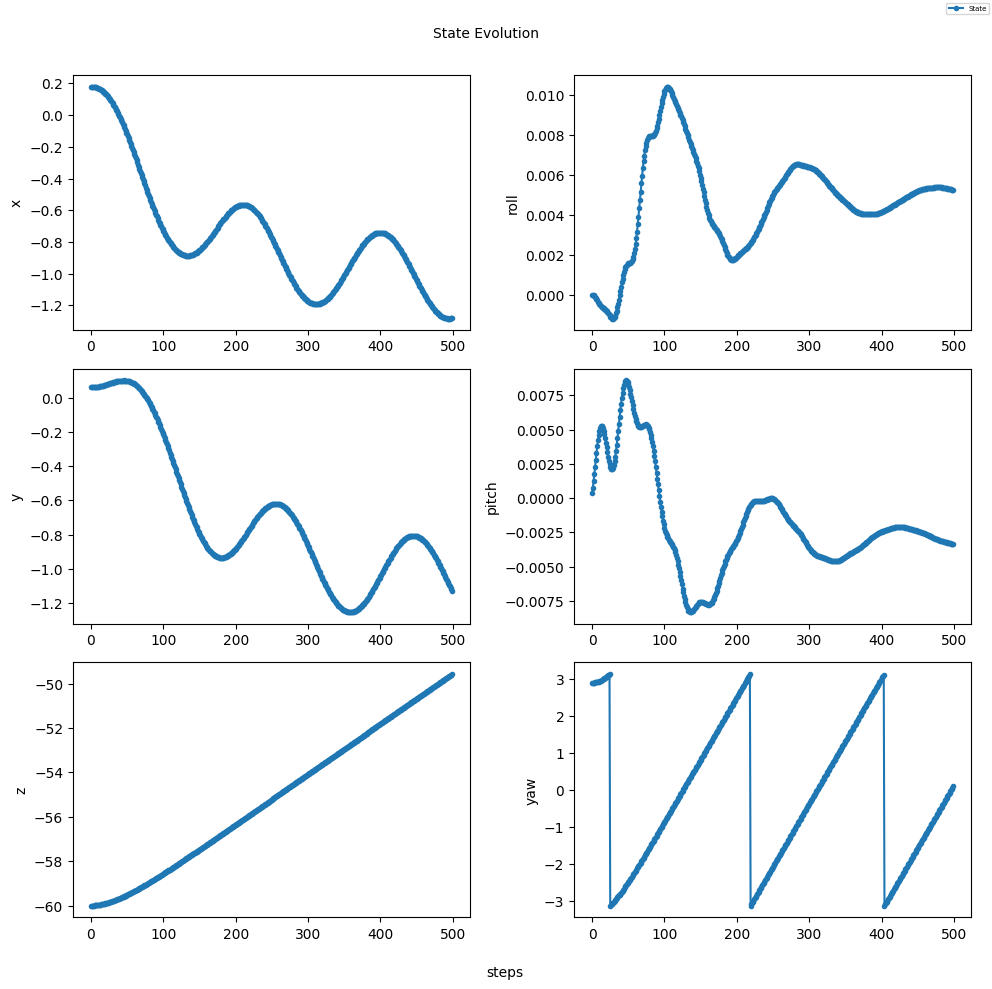

In [13]:

v_cols = {'u': 0, 'v': 1, 'w': 2, 'q': 3, 'p': 4, 'r': 5}
plot_traj({"I_vel": I_vel, "B_vel": B_vel}, v_cols, I_vel.shape[0], True, "velocity")
s_cols = {'x': 0, 'y': 1, 'z': 2, 'roll': 3, 'pitch': 4, 'yaw': 5}
plot_traj({"State": np.concatenate([position, orientation], axis=-1)}, s_cols, position.shape[0], True)

# Perform integration from velocity only.

This is simply starting with $X_0 = \mathcal{E} \oplus Exp(s_0)$.
Then for all the next states, $X_{t+1} = X_{t} \oplus Exp(v_{t}* dt)$

    0.177716    0.0626485     -59.9985     0.123023 -0.000201487  2.17169e-05     0.992404
  -0.0173763     0.116713     -59.9985 -0.000201487  2.17169e-05     0.992404     0.123023


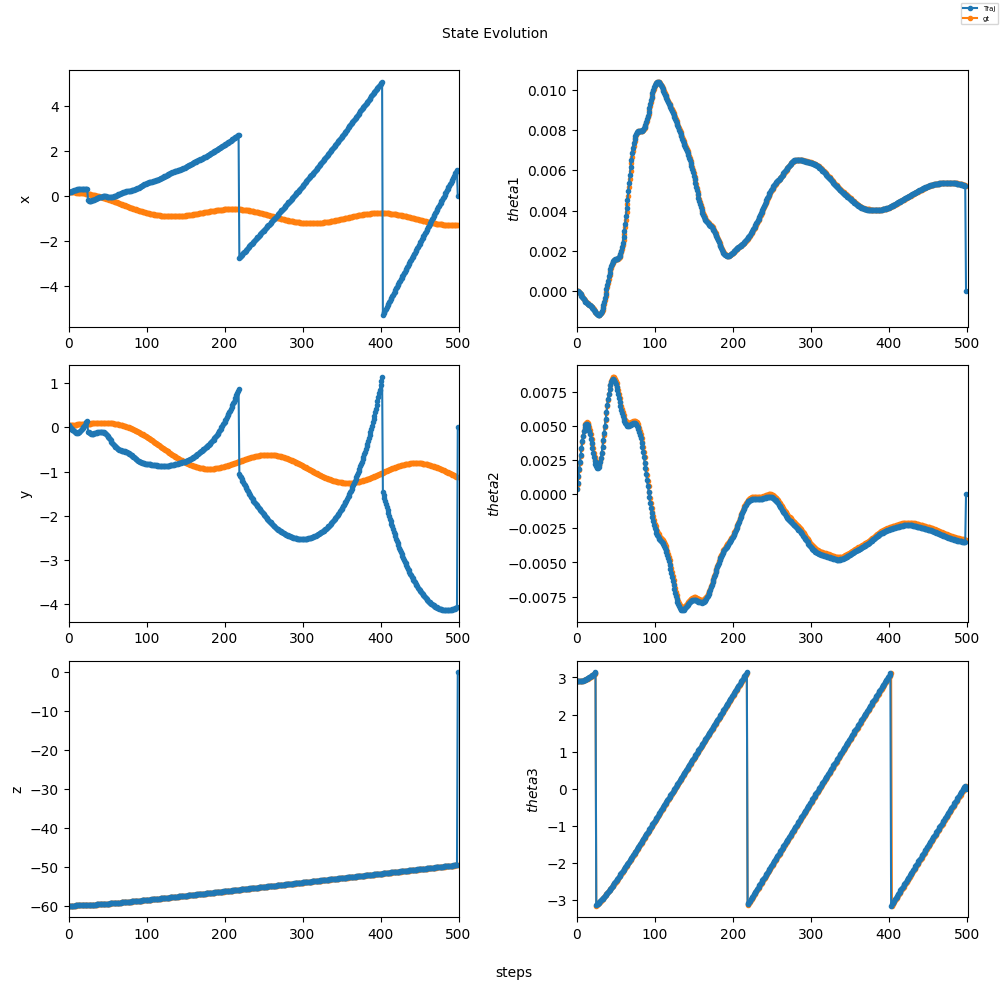

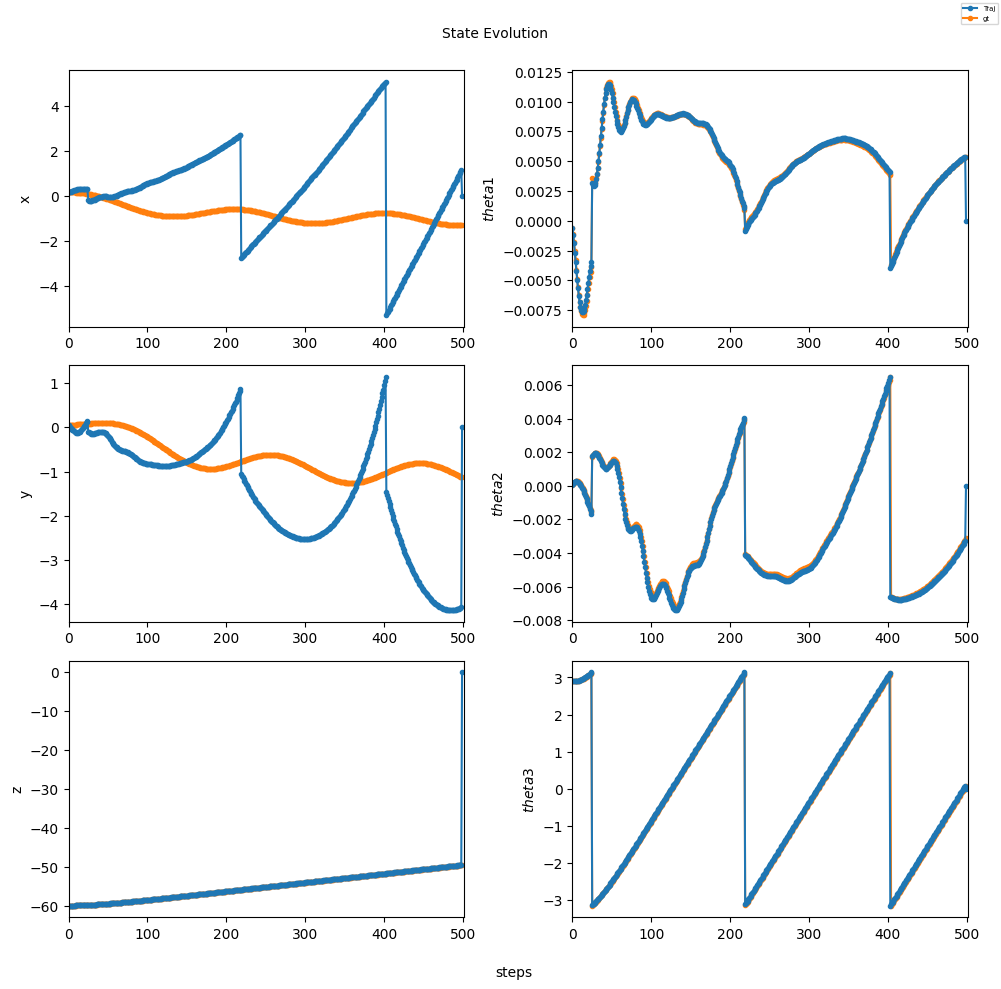

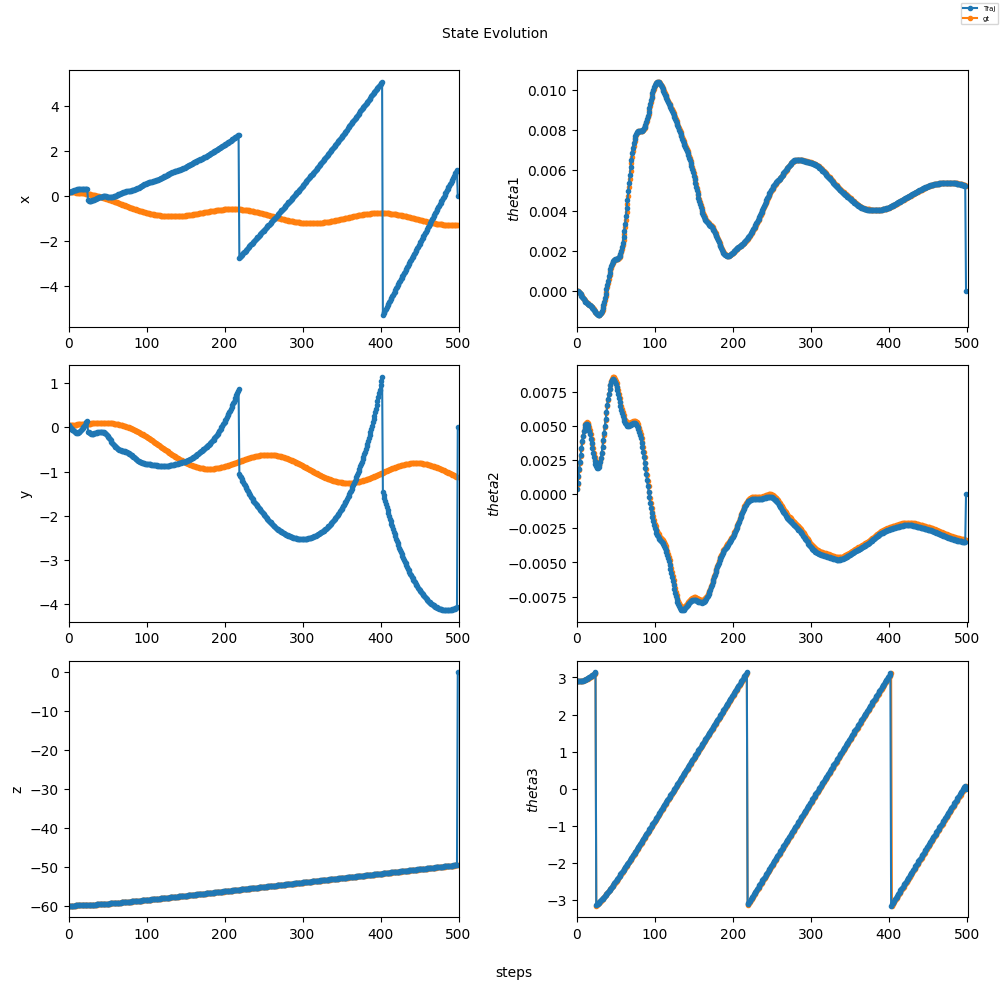

In [37]:
# start with initialization.
dt = 0.1
gt_traj = np.concatenate([position, rot_vec], axis=-1)
gt_traj_euler = np.concatenate([position, orientation], axis=-1)
gt_vel = I_vel
#gt_vel[:, 0] =  vel[:, 1]
#gt_vel[:, 1] =  vel[:, 0]
s0 = gt_traj[0]

X_quat = SE3(position=position[0], quaternion=quat[0])

X = SE3.Identity() + SE3Tangent(s0)

print(X_quat)
print(X)

traj = np.zeros(shape=(gt_traj.shape[0], 6))
traj[0] = np.concatenate([position[0], rot_vec[0]])
traj_euler = np.zeros(shape=(gt_traj.shape[0], 6))
traj_euler[0] = np.concatenate([position[0], orientation[0]])


for i in range(1, gt_traj.shape[0]-1):
    X_next = SE3Tangent(gt_vel[i]*dt) + X
    #X_next.normalize()
    r_vec = X_next.log().coeffs_copy()
    
    p = r_vec[0:3]
    rv = r_vec[3:]
    r = R.from_rotvec(rv)
    euler = r.as_euler('xyz')
    
    traj_euler[i] = np.concatenate([p, euler])
    
    traj[i] = r_vec
    X = X_next


s_cols = {'x': 0, 'y': 1, 'z': 2, '$theta 1$': 3, '$theta 2$': 4, '$theta 3$': 5}
#v_cols = {'u': 0, 'v': 1, 'w': 2, 'q': 3, 'p': 4, 'r': 5}
plot_traj({"Traj": traj, "gt": gt_traj}, s_cols, gt_traj.shape[0], True)

plot_traj({"Traj": traj_euler, "gt": gt_traj_euler}, s_cols, gt_traj.shape[0], True)
#plot_traj({"gt_vel": gt_vel}, v_cols, gt_vel.shape[0], True, "velocity")

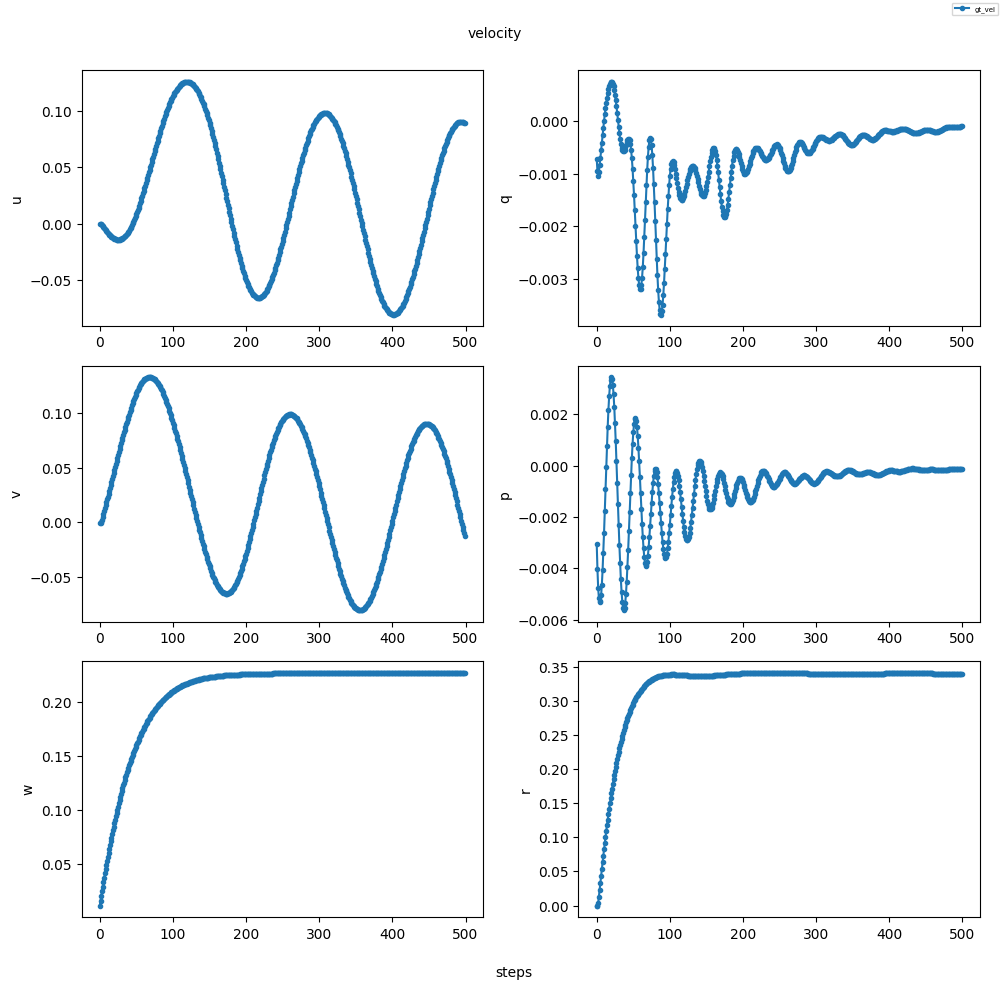

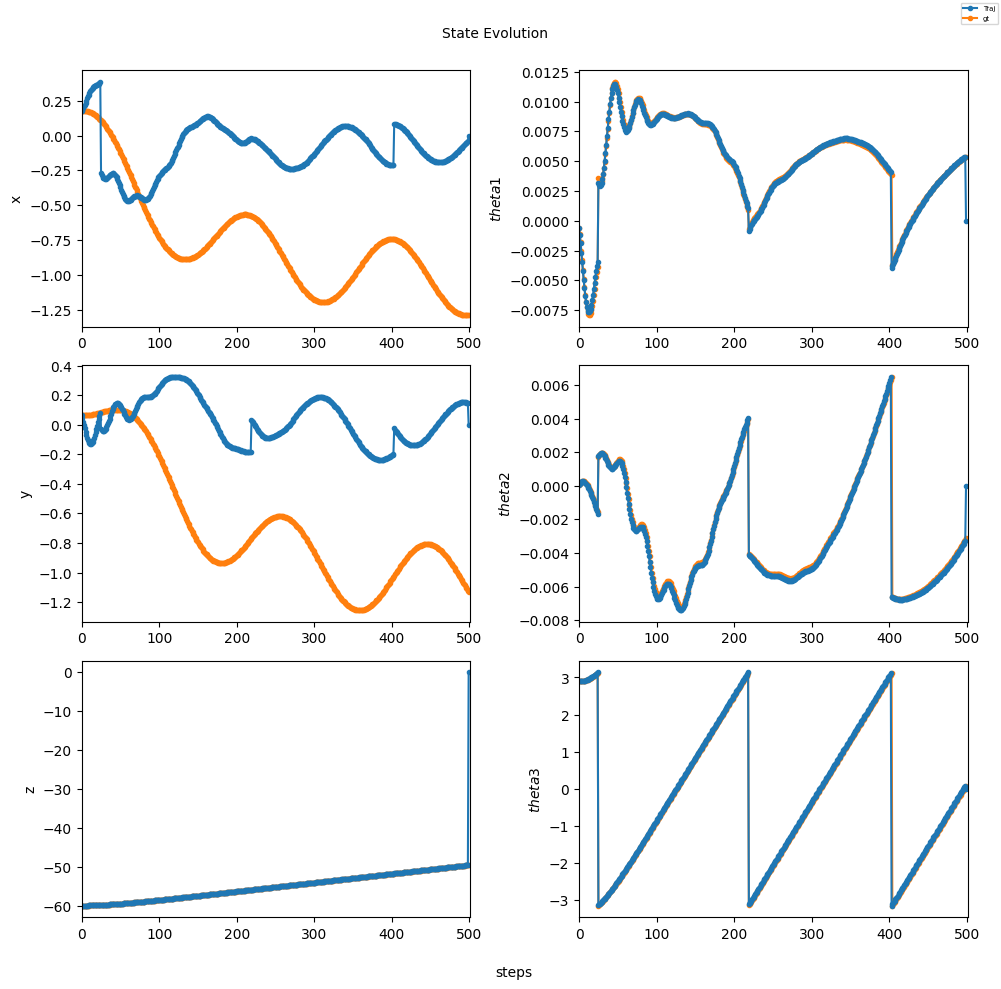

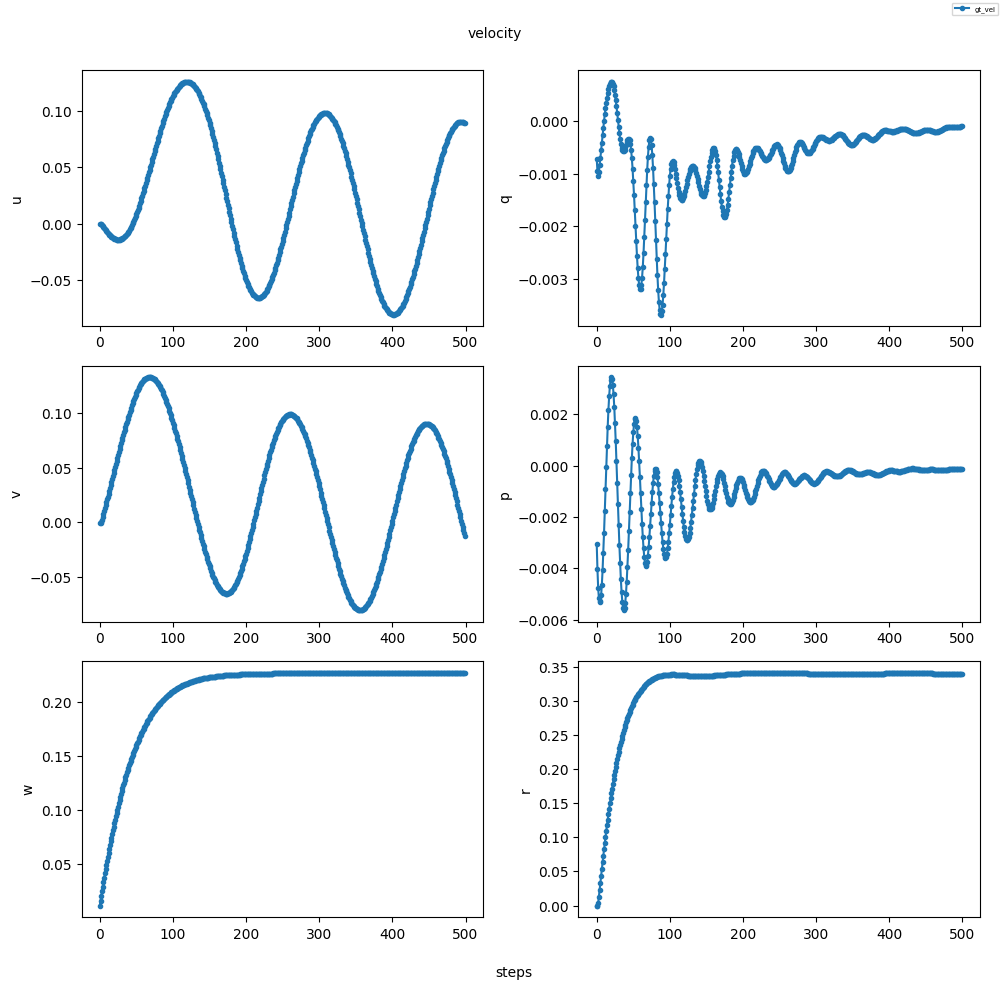

In [96]:
# start with initialization.
dt = 0.1
gt_traj = np.concatenate([position, rot_vec], axis=-1)
gt_vel = vel
gt_vel[:, 0] = - gt_vel[:, 0]
gt_vel[:, 1] = - gt_vel[:, 1]
s0 = gt_traj[0]
X = SE3Tangent(s0) + SE3.Identity()

traj = np.zeros(shape=(gt_traj.shape[0], 6))
traj[0] = s0


for i in range(1, gt_traj.shape[0]-1):
    X_next = SE3Tangent(gt_vel[i]*dt) + X
    #X_next.normalize()
    traj[i] = X_next.log().coeffs_copy()
    X = X_next


s_cols = {'x': 0, 'y': 1, 'z': 2, '$theta 1$': 3, '$theta 2$': 4, '$theta 3$': 5}
v_cols = {'u': 0, 'v': 1, 'w': 2, 'q': 3, 'p': 4, 'r': 5}
plot_traj({"Traj": traj, "gt": gt_traj}, s_cols, gt_traj.shape[0], True)
plot_traj({"gt_vel": gt_vel}, v_cols, gt_vel.shape[0], True, "velocity")

# Let's try to compute $\Delta V$ using manif

First load the trajectory file and split according to *position*, *euler angles*, *rotation matrix*, *linear velocity* and *angular velocity*.


In [42]:
IdvManif = np.zeros(shape=(499, 6))
IvManif = np.zeros(shape=(500, 6))

Create the Lie Group elements using $X = \mathcal{E} \oplus Exp(state)$

Express Velocity in world frame using the adjoing matrix.

Compute $^I \Delta V$ by substracting the two velocity vectors in world frame (Lie Algebra)

In [43]:
for i, s in enumerate(position[:-1]):
    state_t0 = np.concatenate([position[i], rot_vec[i]])
    state_t1 = np.concatenate([position[i+1], rot_vec[i+1]])
    
    X_t0 = SE3.Identity() + SE3Tangent(state_t0)
    X_t1 = SE3.Identity() + SE3Tangent(state_t1)
    
    Ivt0 = np.matmul(X_t0.adj(), vel[i, ..., None])[..., 0]
    Ivt1 = np.matmul(X_t1.adj(), vel[i+1, ..., None])[..., 0]
    
    Iv[i] = Ivt0
    Idv[i] = Ivt1-Ivt0

# Compute $\Delta V$ using our pytorch implementation.

In [62]:
R = torch.Tensor(np.array([[[-1., 0., 0.], [0., -1., 0.], [0., 0., 1.]]]))
R = torch.Tensor(np.array([[[0., -1., 0.,], [1., 0., 0.,], [0., 0., 1.]]]))
R = torch.Tensor(np.array([[[0., 1., 0.,], [-1., 0., 0.,], [0., 0., 1.]]]))
trace = R.diagonal(offset=0, dim1=-1, dim2=-2).sum(-1)
cos = torch.clip(
    ((trace -1.) / 2.),
    -1, 1)

sin = torch.clip(
    (0.5*torch.pow(
        (3-trace)*(1+trace)
        , 0.5)
    ),-1, 1)

theta_sin = torch.atan2(sin, cos)
print(trace)
theta_cos = torch.acos(
            torch.clip(
                ((trace -1.) / 2.),
            -1, 1)
        )
print(theta_sin)
print(theta_cos)

tensor([1.])
tensor([1.5708])
tensor([1.5708])


In [47]:
from RNN_AUV import ToSE2Mat, SE2Adj

In [51]:
se2_mat = ToSE2Mat()
se2_adj = SE2Adj()
print(np.concatenate([position, rot_vec], axis=-1).shape)
X = se2_mat(np.concatenate([position, rot_vec], axis=-1))

(500, 6)


TypeError: cos(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

# Plot state and velocities

(499, 6)


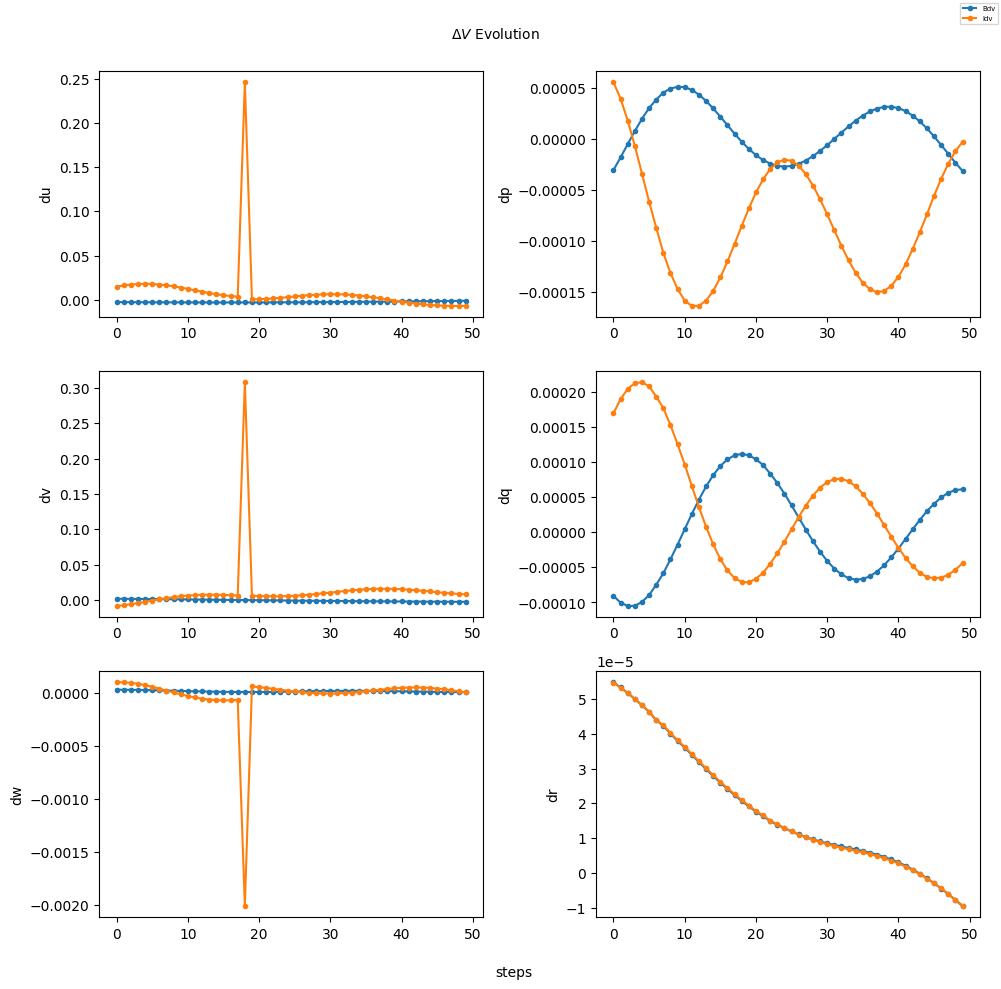

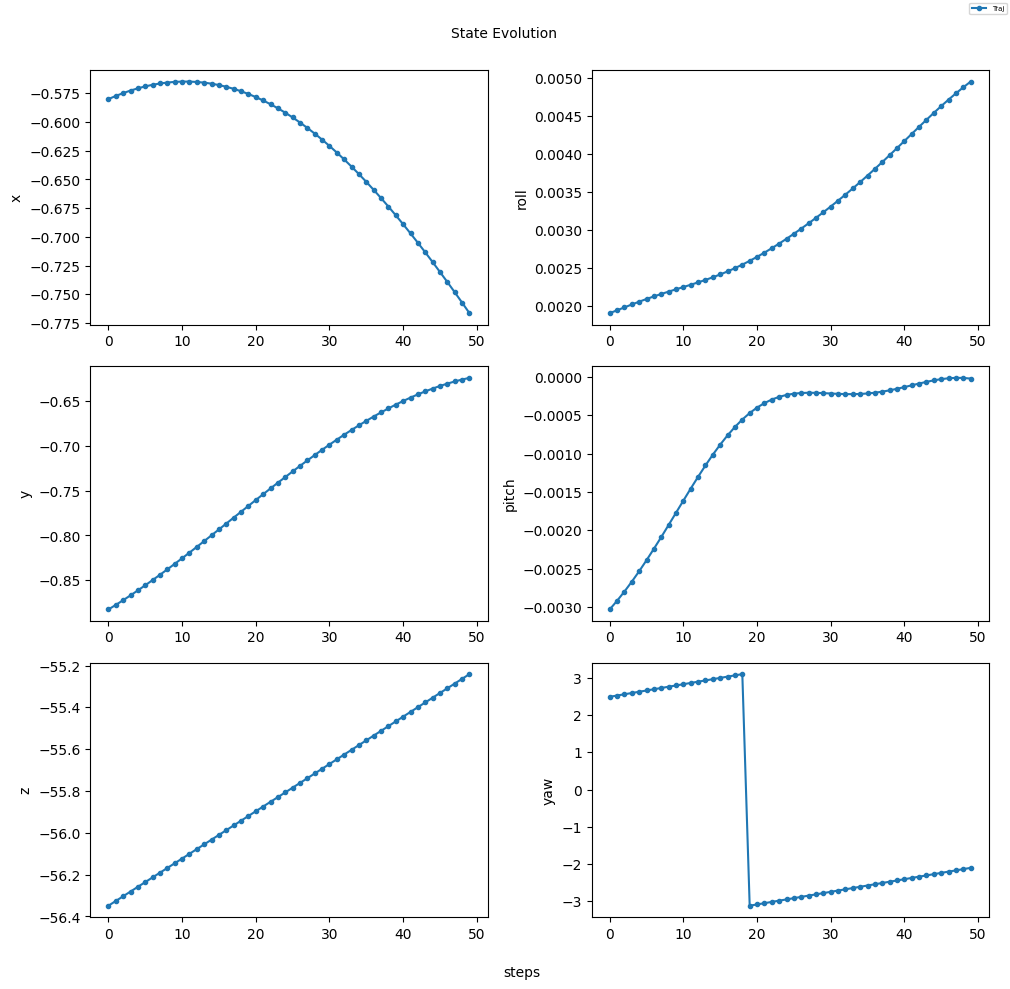

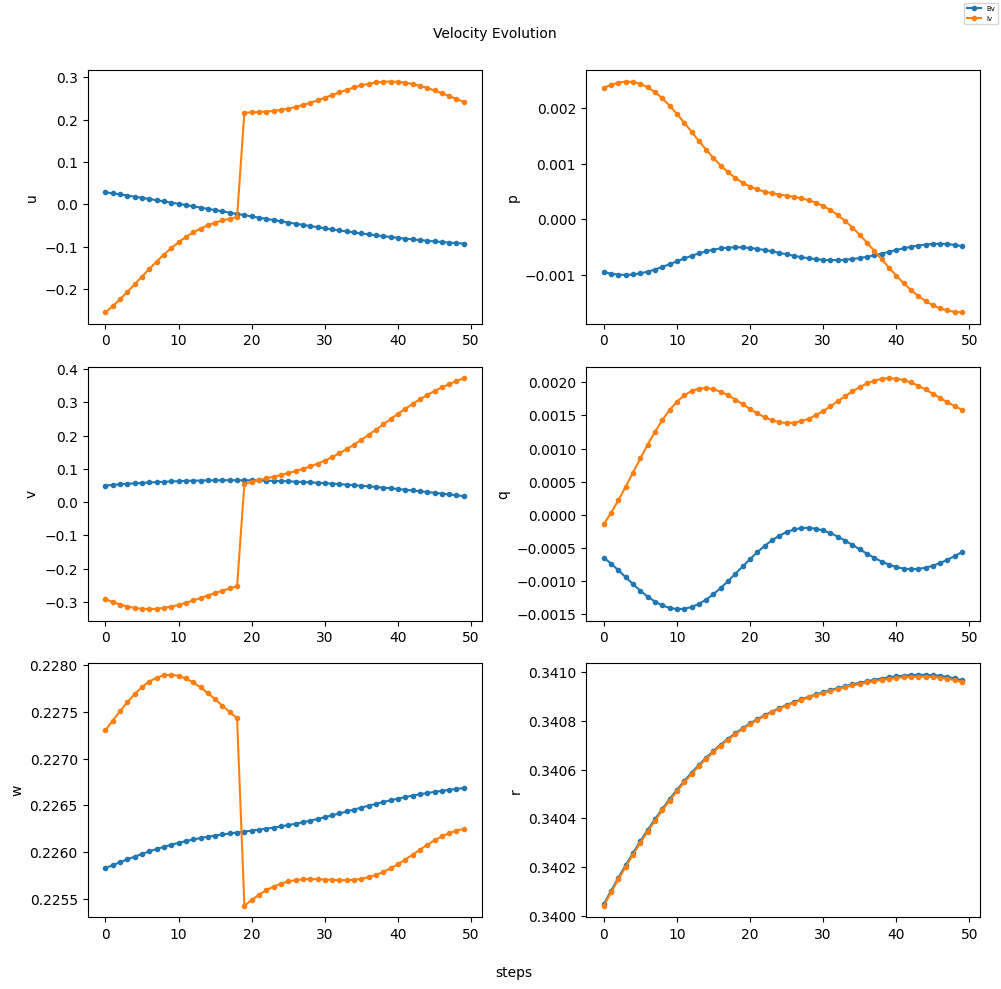

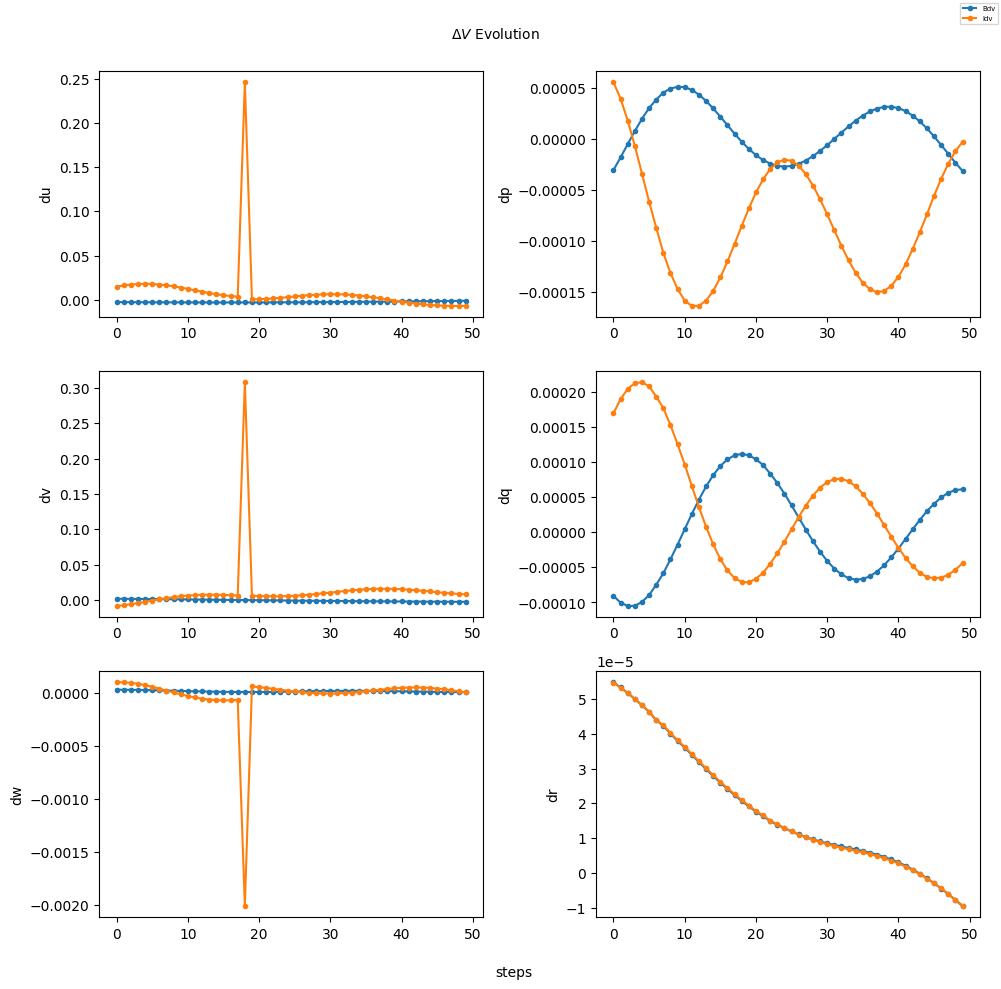

In [39]:
traj = np.concatenate([position, orientation], axis=-1)
dv = vel[1:] - vel[:-1]
print(dv.shape)

s_cols = {'x': 0, 'y': 1, 'z': 2, 'roll': 3, 'pitch': 4, 'yaw': 5}
vel_cols = {'u': 0, 'v': 1, 'w': 2, 'p': 3, 'q': 4, 'r': 5}
dv_cols = {'du': 0, 'dv': 1, 'dw': 2, 'dp': 3, 'dq': 4, 'dr': 5}
#print(traj.shape)
plot_traj({"Traj": traj[200:250]}, s_cols, 50, True)
plot_traj({"Bv": vel[200:250], "Iv": Iv[200:250]}, vel_cols, 50, True, "Velocity Evolution")
plot_traj({"Bdv": dv[200:250], "Idv": Idv[200:250]}, dv_cols, 50, True, "$\Delta V$ Evolution")

In [37]:
print("Pos0: \n", position[0])
print("rot0: \n", orientation[0])
print("Pos1: \n", position[1])
print("rot1: \n", orientation[1])
print("Bv0:  \n", Bv0)
print("Bv1:  \n", Bv1)
print("Bdv0: \n", (Bv1-Bv0))
print("Iv0:  \n", Iv0)
print("Iv1:  \n", Iv1)
print("Idv0: \n", Idv0)

Pos0: 
 [  0.17771606   0.0626485  -59.99847926]
rot0: 
 [-6.47097884e-06  4.05255670e-04  2.89492240e+00]
Pos1: 
 [  0.17779636   0.06265162 -59.99707081]
rot1: 
 [-1.19986624e-05  7.67832762e-04  2.89490806e+00]
Bv0:  
 [ 6.77789977e-04  2.61231180e-05  1.18910743e-02 -7.15396156e-04
 -3.04276810e-03 -1.21076054e-04]
Bv1:  
 [ 9.36109326e-04  3.65846911e-05  1.64304079e-02 -9.52980690e-04
 -4.03467582e-03 -1.66960645e-04]
Bdv0: 
 [ 2.58319349e-04  1.04615731e-05  4.53933353e-03 -2.37584534e-04
 -9.91907715e-04 -4.58845911e-05]
Iv0:  
 [ 1.65871774e-01 -8.60643908e-02  1.16748735e-02  1.43676148e-03
  2.77597203e-03 -1.20766436e-04]
Iv1:  
 [ 2.19830366e-01 -1.14368977e-01  1.61927755e-02  1.90948448e-03
  3.67979756e-03 -1.66180456e-04]
Idv0: 
 [ 5.39585920e-02 -2.83045861e-02  4.51790195e-03  4.72723001e-04
  9.03825529e-04 -4.54140194e-05]


/tmp/ipykernel_7840/723131693.py:24: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


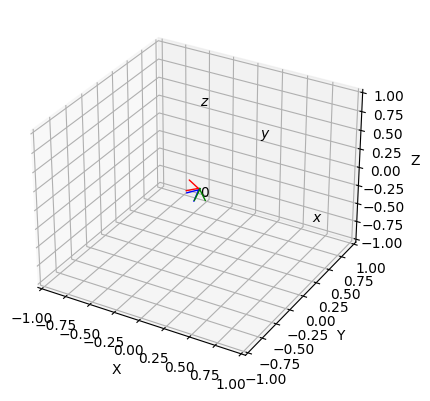

In [35]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d



class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)
        
    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)


def cuboid_data(center, size):
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the (left, outside, bottom) point
    o = [a - b / 2 for a, b in zip(center, size)]
    # get the length, width, and height
    l, w, h = size
    x = np.array([[o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in bottom surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in upper surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  # x coordinate of points in outside surface
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]])  # x coordinate of points in inside surface
    y = np.array([[o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in bottom surface
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  # y coordinate of points in upper surface
         [o[1], o[1], o[1], o[1], o[1]],          # y coordinate of points in outside surface
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]])    # y coordinate of points in inside surface
    z = np.array([[o[2], o[2], o[2], o[2], o[2]],                        # z coordinate of points in bottom surface
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],    # z coordinate of points in upper surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],                # z coordinate of points in outside surface
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]])                # z coordinate of points in inside surface
    return x, y, z



center = [0, 0, 0]
length = 1e-2
width = 1e-2
height = 1e-2
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
X, Y, Z = cuboid_data(center, (length, width, height))
ax1.plot_surface(X, Y, Z, color='b', rstride=1, cstride=1, alpha=0.1)
ax1.set_xlabel('X')
ax1.set_xlim(-1, 1)
ax1.set_ylabel('Y')
ax1.set_ylim(-1, 1)
ax1.set_zlabel('Z')
ax1.set_zlim(-1, 1)

# Here we create the arrows:
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)


a = Arrow3D([0, Bv0[0]], [0, 0], [0, 0], **arrow_prop_dict, color='r')
ax1.add_artist(a)
a = Arrow3D([0, 0], [0, Bv0[1]], [0, 0], **arrow_prop_dict, color='b')
ax1.add_artist(a)
a = Arrow3D([0, 0], [0, 0], [0, Bv0[2]], **arrow_prop_dict, color='g')
ax1.add_artist(a)

# Give them a name:
ax1.text(0.0, 0.0, -0.1, r'$0$')
ax1.text(1.1, 0, 0, r'$x$')
ax1.text(0, 1.1, 0, r'$y$')
ax1.text(0, 0, 1.1, r'$z$')

plt.show()